# Predicting Boots as First Buy in League of Legends

## Summary

  Goal: Binary prediction of whether a player buys boots as their first purchase after starting items.
  
  Data: 112380 rows, 26 features. Gathered with Riot API timeline for matches of matchIDs from a Kaggle dataset.
  
  Methods: Decision Tree, Random Forest, Logistic Regression, SVM, XGBoost, Grid Search
  
  Results: 80.3% accuracy achieved. Gold, position, mastery are found to be strongest predictors. Attack Damage is surprisingly predictive.



## Introduction
League of Legends (LOL) is a 5 versus 5, player versus player game where we play as champions. To win, players must gather gold outside their base, then return base to buy items to improve their champion's power. Among the items, boots is a cheap yet critical item that improves a champion's movement speed. Although it is important, whether to buy boots the first time a player returns to base is highly situational. The goal of the project is to predict this situational choice and unveil the process.

Our dataset starts from 12,000 IDs of League of Legends matches, found at https://www.kaggle.com/datasets/sabrinasummers/league-of-legends-diamond-matches-preseason-12. For each match, I gathered the detailed match data through League of Legends API (https://developer.riotgames.com/). The process isn't easy and my data-gathering code can be found in loldata.ipynb.

Each row in our dataset represents a player in a match. The label is whether the player buys boots or not on his first return. The groups of features included are: 
- champion characteristics: How much does your champion need boots?
- opponent characteristics: Is buying boots first a good choice against this particular champion?
- early game performance: Before you buy boots, are you having a successful early game or falling behind?
- player's role in the team: Some roles (UTILITY in particular) requires more moving and an early boots can be helpful.
- player gold amount: Can you afford boots? Can you afford boots + another item?
- game time: How long the game has started.
- pre-game champion setup: Some decisions that affect champion statistics and playstyle. One setup gifts you a boots after several - minutes, but prevent you from buying it manually.

In each game there's 10 players, so we're supposed to have 120,000 rows in total.

## Cleaning and Preprocessing
### Raw Data Overview

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv('loldatafull.csv',index_col = 0)
data.shape

(119046, 29)

In [2]:
# Balance on Label
data.label.value_counts()

False    81283
True     37763
Name: label, dtype: int64

In [3]:
data.head()

,championName,firstBloodAssist,firstBloodKill,individualPosition,summoner1Id,summoner2Id,participantId,perks,enemyId,enemyName,...,xp,minionsKilled,jungleMinionsKilled,attackDamage,armor,magicResist,healthMax,healthRegen,powerMax,lifesteal
championId,,,,,,,,,,,,,,,,,,,,,
85,Kennen,True,False,TOP,12,4,1,"{'statPerks': {'defense': 5003, 'flex': 5008, ...",17,Teemo,...,1572,24,0,56,37,39,951,13,200,0
245,Ekko,False,False,JUNGLE,4,11,2,"{'statPerks': {'defense': 5002, 'flex': 5008, ...",120,Hecarim,...,320,0,4,60,40,32,646,19,330,0
157,Yasuo,False,False,MIDDLE,14,4,3,"{'statPerks': {'defense': 5003, 'flex': 5008, ...",7,Leblanc,...,2655,46,0,77,43,44,913,32,145,0
119,Draven,False,True,BOTTOM,4,7,4,"{'statPerks': {'defense': 5002, 'flex': 5008, ...",498,Xayah,...,536,13,0,85,37,30,749,8,413,0
12,Alistar,False,False,UTILITY,4,14,5,"{'statPerks': {'defense': 5001, 'flex': 5002, ...",350,Yuumi,...,566,3,0,67,52,32,728,22,378,0


List of Features.

Col 7 "perks" is entire mastery setup (Keystone, Primary, Secondary, Steriods).  

Col 16 "label" is what we try to predict. 

Col 15 - 28 are live stats from the minute they made their first purchase.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119046 entries, 85 to 43
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   championName         119046 non-null  object
 1   firstBloodAssist     119046 non-null  bool  
 2   firstBloodKill       119046 non-null  bool  
 3   individualPosition   119046 non-null  object
 4   summoner1Id          119046 non-null  int64 
 5   summoner2Id          119046 non-null  int64 
 6   participantId        119046 non-null  int64 
 7   perks                119046 non-null  object
 8   enemyId              119046 non-null  int64 
 9   enemyName            119046 non-null  object
 10  cmovespeed           119046 non-null  int64 
 11  cattackrange         119046 non-null  int64 
 12  emovespeed           119046 non-null  int64 
 13  eattackrange         119046 non-null  int64 
 14  matchId              119046 non-null  object
 15  minute               119046 non-null 

### 'Missing' Data Handling
We're supposed to have 120,000 players from 12,000 matches, but only have 119046. My data gathering logs show that for some matches we got >10 or <10 players in them. Such matches are of questionable quality and player boots buying decisions there probably couldn't be explained well by our model. For example, if my teammates failed to connect (having less than 10 players in total), then I won't play seriously since I'm almost guaranteed to lose. If the API said there's more than 10 players in this match, there's definitely something wrong on the game or on the API, and data gathered there can't be trusted.

Since we don't want such matches to disturb our model we're dropping rows where the match that the row is part of does not have exactly 10 players. Dropping them seems the only possible option, since we can't fill entire rows and the 'survived' rows are possibly polluted.

In [5]:
goodmatch = data.matchId.value_counts().index[data.matchId.value_counts() == 10]
print(goodmatch.shape)
data = data[data.matchId.apply(lambda x: x in goodmatch)]
data.shape

(11238,)


(112380, 29)

In [6]:
# Dropping features we don't use
use = data.drop([ 'participantId','enemyId','matchId'],axis = 1)
use.shape

(112380, 26)

### Balancing

In [7]:
ntrue = use.label.value_counts()[1]
print(ntrue)
sampledfalse = use[use.label == False].sample(n = ntrue, random_state = 42)
print(sampledfalse.shape)

35557
(35557, 26)


In [8]:
balanced = pd.concat([use[use.label == True],sampledfalse],axis = 0)
print(balanced.shape)
print(balanced.label.value_counts())

(71114, 26)
True     35557
False    35557
Name: label, dtype: int64


### Feature Representation
We have some categorical feature that needs to be coded. I'm using one hot encoder here.

'Perks', a pre-match setup, is a multi-level nested json-like string that took some cleaning to break down into 9 features (before ohe).

'Summoner1Id' and 'Summoner2Id' are two summoner spells that a player chooses to bring, also a pre-game setup. Interesting part is the order of them doesn't matter. For example, say there are 3 summoner spells: Flash, Ignite, Ghost. ['Flash','Ignite'] should be represented the same way as ['Ignite','Flash']. You still have the same 2 spells under your sleeve. I implemented this characteristic in my representation.

In [16]:
#What I'm working with
balanced.perks.iloc[0]

"{'statPerks': {'defense': 5003, 'flex': 5008, 'offense': 5008}, 'styles': [{'description': 'primaryStyle', 'selections': [{'perk': 8214, 'var1': 1666, 'var2': 0, 'var3': 0}, {'perk': 8275, 'var1': 7, 'var2': 0, 'var3': 0}, {'perk': 8210, 'var1': 12, 'var2': 0, 'var3': 0}, {'perk': 8237, 'var1': 629, 'var2': 0, 'var3': 0}], 'style': 8200}, {'description': 'subStyle', 'selections': [{'perk': 8139, 'var1': 1126, 'var2': 0, 'var3': 0}, {'perk': 8135, 'var1': 2190, 'var2': 5, 'var3': 0}], 'style': 8100}]}"

In [17]:
import json
def perk2dict(s):
    '''
    Replaces single quote with double quote to meet json requirements, then convert perk strings into
    json-style dictionary.

    perks: string of perks from lol API.
    '''
    s = s.replace("'",'"')
    dict = json.loads(s)
    return dict

In [18]:
balanced['perks'] = balanced.perks.apply(perk2dict)

In [19]:
# 3 statperks
stats3s = pd.json_normalize(balanced.perks)
# Other perks nested deeper
styles = pd.json_normalize(stats3s.styles)
primary = pd.json_normalize(pd.json_normalize(styles[0]).selections).applymap(lambda x: x.get('perk'))
sub = pd.json_normalize(pd.json_normalize(styles[1]).selections).applymap(lambda x: x.get('perk'))

In [22]:
# df of perks
mastery = pd.concat([stats3s[stats3s.columns[1:4]],primary,sub],axis = 1)
mastery.columns = mastery.columns[0:3].tolist() + ['keystone','p1','p2','p3','s1','s2']
mastery.index = balanced.index #Lost index during json_normalize, adding it back
mastery.head()

,statPerks.defense,statPerks.flex,statPerks.offense,keystone,p1,p2,p3,s1,s2
championId,,,,,,,,,
85,5003,5008,5008,8214,8275,8210,8237,8139,8135
157,5003,5008,5005,8008,9111,9104,8014,8444,8242
17,5001,5008,5005,8214,8226,8233,8236,8139,8135
120,5001,5008,5005,8124,8143,8138,8134,8234,8232
60,5002,5008,5005,8005,9111,9104,8014,8126,8134


In [23]:
# Converting IDs to Names using dict for better interpretation
ssd = pd.read_csv('ssd.csv',index_col=0,squeeze=True) #From Riot API
ssd = ssd.to_dict()
runesd = pd.read_csv('runesd.csv',index_col=0,squeeze=True) 
runesd = runesd.to_dict() # dict for perks
mastery = mastery.replace(runesd)
mastery.head()

,statPerks.defense,statPerks.flex,statPerks.offense,keystone,p1,p2,p3,s1,s2
championId,,,,,,,,,
85,Magic Resist,Adaptive Force,Adaptive Force,SummonAery,NimbusCloak,Transcendence,Scorch,TasteOfBlood,RavenousHunter
157,Magic Resist,Adaptive Force,Attack Speed,LethalTempo,Triumph,LegendAlacrity,CoupDeGrace,SecondWind,Unflinching
17,Scaling Health,Adaptive Force,Attack Speed,SummonAery,ManaflowBand,AbsoluteFocus,GatheringStorm,TasteOfBlood,RavenousHunter
120,Scaling Health,Adaptive Force,Attack Speed,Predator,SuddenImpact,EyeballCollection,IngeniousHunter,Celerity,Waterwalking
60,Armor,Adaptive Force,Attack Speed,PressTheAttack,Triumph,LegendAlacrity,CoupDeGrace,CheapShot,IngeniousHunter


In [24]:
# perks ready for ohe, adding it to data
balanced = pd.concat([balanced,mastery], axis = 1)
balanced = balanced.drop('perks',axis = 1)


In [25]:
#Preprocessing summoner spells

balanced.summoner1Id = balanced.summoner1Id.replace(ssd)
balanced.summoner2Id = balanced.summoner2Id.replace(ssd)
summids = balanced.summoner1Id.unique().tolist()
print(summids)

['SummonerTeleport', 'SummonerDot', 'SummonerHaste', 'SummonerFlash', 'SummonerHeal', 'SummonerSmite', 'SummonerBoost', 'SummonerExhaust', 'SummonerBarrier']


In [26]:
# Combining two columns into 1
combined = balanced[['summoner1Id','summoner2Id']].values
combined

array([['SummonerTeleport', 'SummonerFlash'],
       ['SummonerDot', 'SummonerFlash'],
       ['SummonerDot', 'SummonerFlash'],
       ...,
       ['SummonerFlash', 'SummonerDot'],
       ['SummonerTeleport', 'SummonerFlash'],
       ['SummonerFlash', 'SummonerHeal']], dtype=object)

In [27]:
# Creating a Boolean Series for each summoner spell
for i in summids:
    result = []
    for c in combined:
        result.append(i in c)
    balanced[i] = result

In [28]:
#Check rightmost columns for newly added summoner spell data. Already ohe-ed.
balanced = balanced.drop(['summoner1Id','summoner2Id'],axis = 1)
balanced.head()

,championName,firstBloodAssist,firstBloodKill,individualPosition,enemyName,cmovespeed,cattackrange,emovespeed,eattackrange,minute,...,s2,SummonerTeleport,SummonerDot,SummonerHaste,SummonerFlash,SummonerHeal,SummonerSmite,SummonerBoost,SummonerExhaust,SummonerBarrier
championId,,,,,,,,,,,,,,,,,,,,,
85,Kennen,True,False,TOP,Teemo,335,550,330,500,4,...,RavenousHunter,True,False,False,True,False,False,False,False,False
157,Yasuo,False,False,MIDDLE,Leblanc,345,175,340,525,5,...,Unflinching,False,True,False,True,False,False,False,False,False
17,Teemo,False,False,TOP,Kennen,330,500,335,550,3,...,RavenousHunter,False,True,False,True,False,False,False,False,False
120,Hecarim,False,False,JUNGLE,Ekko,345,175,340,125,3,...,Waterwalking,False,False,True,False,False,True,False,False,False
60,Elise,False,True,JUNGLE,Shaco,330,550,345,125,2,...,IngeniousHunter,False,False,False,True,False,True,False,False,False


In [30]:
# Feature table before ohe
y = balanced.label
X = balanced.drop('label',axis = 1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71114 entries, 85 to 202
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   championName         71114 non-null  object
 1   firstBloodAssist     71114 non-null  bool  
 2   firstBloodKill       71114 non-null  bool  
 3   individualPosition   71114 non-null  object
 4   enemyName            71114 non-null  object
 5   cmovespeed           71114 non-null  int64 
 6   cattackrange         71114 non-null  int64 
 7   emovespeed           71114 non-null  int64 
 8   eattackrange         71114 non-null  int64 
 9   minute               71114 non-null  int64 
 10  totalGold            71114 non-null  int64 
 11  level                71114 non-null  int64 
 12  xp                   71114 non-null  int64 
 13  minionsKilled        71114 non-null  int64 
 14  jungleMinionsKilled  71114 non-null  int64 
 15  attackDamage         71114 non-null  int64 
 16  armor

In [31]:
#ohe all categorical features
X = pd.get_dummies(X)
X.shape

(71114, 508)

### Train-test split

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [33]:
print('train',y_train.value_counts())
print('test',y_test.value_counts())

train True     23846
False    23800
Name: label, dtype: int64
test False    11757
True     11711
Name: label, dtype: int64


# Simple DT with grid search and CV

This model took roughly an hour to fit, with 350 fits. Each fit takes roughly 10 seconds.

In [34]:
# Simple DT with grid search and cv
from sklearn import tree
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier(random_state=42)

In [59]:
criterion = ['gini', 'entropy'] 
max_depth = [10,20,40,None] 
min_samples_leaf = [1,10,100,1000] 
min_samples_split=[2,20,200,2000] 
min_impurity_decrease = [0.0, 0.01,0.1]

parameters = dict(criterion=criterion,
                  max_depth=max_depth,
                  min_samples_leaf = min_samples_leaf,
                  min_samples_split = min_samples_split,
                  min_impurity_decrease = min_impurity_decrease)

clf_GS = GridSearchCV(clf,param_grid=parameters)
clf_GS.fit(X_train,y_train)
best = clf_GS.best_estimator_
clf_GS.best_score_

0.7933300708931051

In [60]:
#Evalutation on test set
best.score(X_test, y_test)

0.7909919890915289

In [61]:
best.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 10,
 'min_samples_split': 200,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

### Evaluation

We reached 79% accuracy in test set. From confusion matrix, we are making much more False Positives than False Negatives. In other words, the tree tends to predict players would buy boots when they actually don't.

In [40]:
y_pred = best.predict(X_test)
cm= pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
#https://datatofish.com/confusion-matrix-python/
print (cm)

Predicted  False  True
Actual                
False       8727  3030
True        1875  9836


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.74      0.78     11757
        True       0.76      0.84      0.80     11711

    accuracy                           0.79     23468
   macro avg       0.79      0.79      0.79     23468
weighted avg       0.79      0.79      0.79     23468



AUC score is 0.7910876554123313


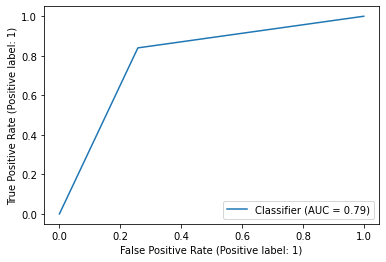

In [192]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
print('AUC score is', roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_pred)

### Visualizaiton

Below I visualized the first 4 layers of our best tree. As can be seen, Magical Footwear (that prevents you from buying boots) and total gold (800 being starting items + boots) are used as first predictors, as we expect. Yuumi (who usually doesn't buy boots) comes as another splitting feature.

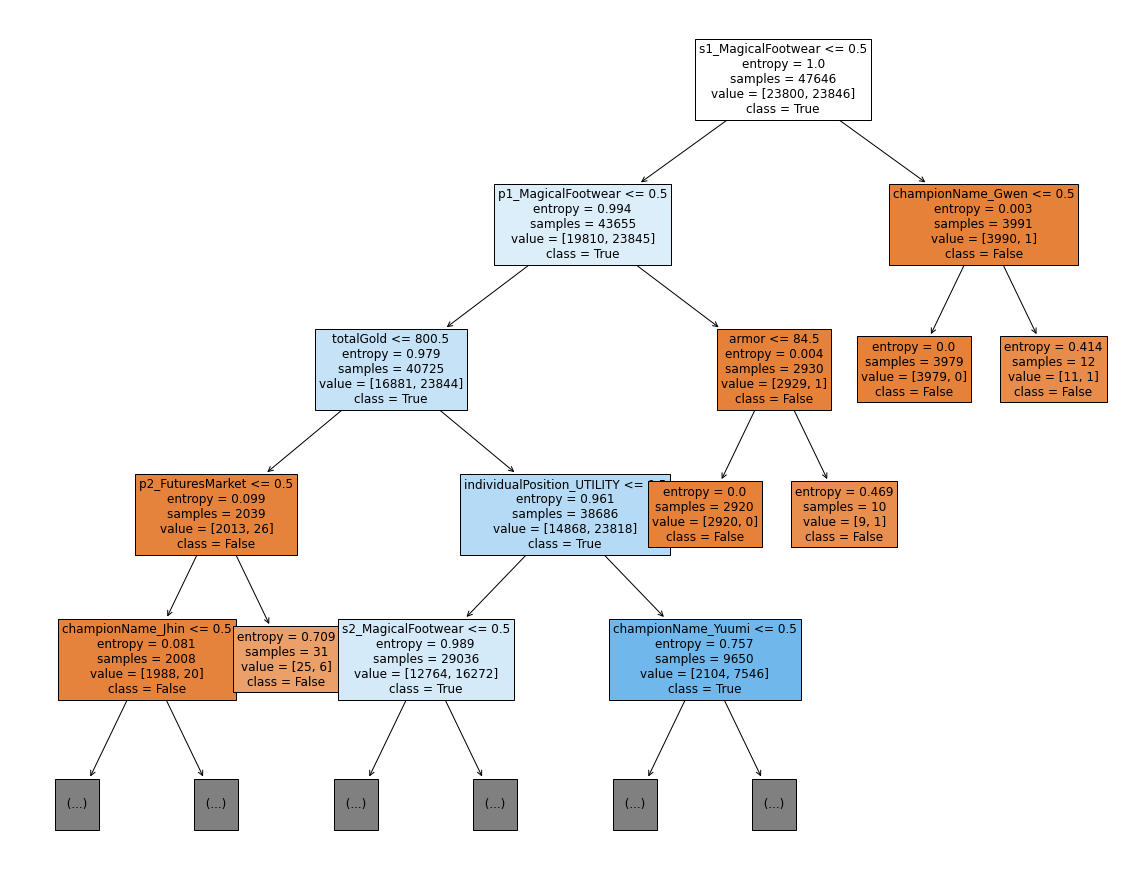

In [56]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20,16))
tree.plot_tree(best, max_depth = 4, feature_names= fn, class_names=cn, filled = True, fontsize = 12)
plt.show()

In [66]:
importances = pd.Series(best.feature_importances_, index = best.feature_names_in_)
importances = importances.sort_values(ascending=False)

Top 10 most important features are shown below using Mean Decrease in Inpurity. It's surprising to see attack damage as the third most important features, only after gold amount and magical footwear.

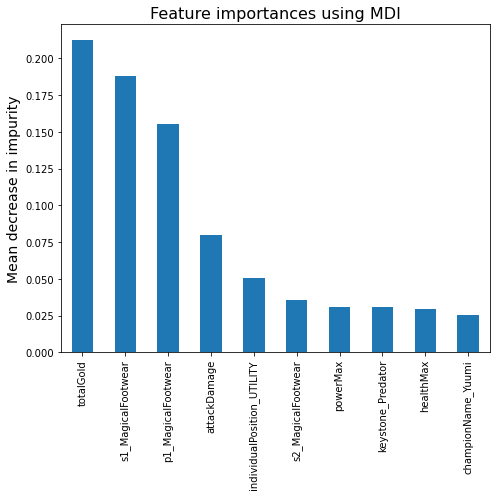

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(7,7)
importances[0:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI", fontsize = 16)
ax.set_ylabel("Mean decrease in impurity", fontsize = 14)
fig.tight_layout()

## Random Forests

Random forest improves our accuracy by roughly 0.6% and results in a more balanced error distribution. Still, we see more false positives than false negatives. (higher true class recall than precision)

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state= 42)

parameters = dict(n_estimators = [200,400,600],
                  criterion = ['gini','entropy'],
                  max_depth = [10,20,40,None],
                 max_features = ['auto','sqrt','log2'],
                 min_samples_leaf = [2,5,10,100],
                  min_samples_split = [4,10,20,200],
                  bootstrap = [True,False]
                 )


rf_random = RandomizedSearchCV(estimator = rf, param_distributions=parameters, verbose = 2,random_state = 42, n_jobs= -1, cv = 3)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 40, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 5, 10, 100],
                                        'min_samples_split': [4, 10, 20, 200],
                                        'n_estimators': [200, 400, 600]},
                   random_state=42, verbose=2)

In [73]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 20,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': False}

In [78]:
rf_random.score(X_test, y_test)

0.7961905573546958

In [79]:
y_pred = rf_random.predict(X_test)
cm= pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print (cm)

Predicted  False  True
Actual                
False       8981  2776
True        2007  9704


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.76      0.79     11757
        True       0.78      0.83      0.80     11711

    accuracy                           0.80     23468
   macro avg       0.80      0.80      0.80     23468
weighted avg       0.80      0.80      0.80     23468



AUC score is 0.7962540036775065


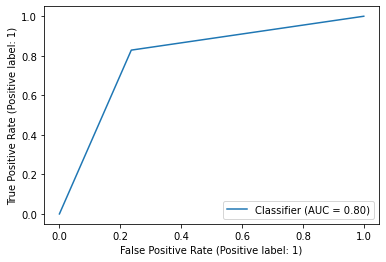

In [81]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
print('AUC score is', roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_pred)

### Visualizaiton

Below I visualized the first 4 layers of our best tree. As can be seen, Magical Footwear (that prevents you from buying boots) and total gold (800 being starting items + boots) are used as first predictors, as we expect. Yuumi (who usually doesn't buy boots) comes as another splitting feature.

In [83]:
rfexample = rf_random.estimators_[42]
plt.figure(figsize = (20,16))
tree.plot_tree(rfexample, max_depth = 4, feature_names= fn, class_names=cn, filled = True, fontsize = 12)
plt.show()

AttributeError: 'RandomizedSearchCV' object has no attribute 'estimators_'

In [66]:
importances = pd.Series(best.feature_importances_, index = best.feature_names_in_)
importances = importances.sort_values(ascending=False)

Top 10 most important features are shown below using Mean Decrease in Inpurity. It's surprising to see attack damage as the third most important features, only after gold amount and magical footwear.

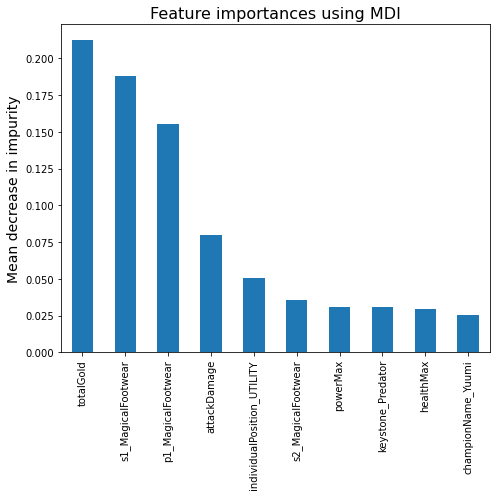

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(7,7)
importances[0:10].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI", fontsize = 16)
ax.set_ylabel("Mean decrease in impurity", fontsize = 14)
fig.tight_layout()

## Logistic Regression Classifier (with Polynomial Representation)
Logistic Regression took roughly 2 hours for 315 maximum possible fits. Suppose 80% of them are good (some penalties don't work with certain solver), each fits requires rougly 30 seconds.

In [24]:
# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
# Logistic Regression Classifier with Grid Search and CV
from sklearn.linear_model import LogisticRegression
logclf = LogisticRegression(random_state = 42)
penalty = ['none','l1','l2']
solver = ['newton-cg', 'lbfgs', 'liblinear']
C = [0.001,0.01,0.1,1,10,100,1000]
parameters = dict(penalty = penalty, C = C, solver = solver)
log_GS = GridSearchCV(logclf,parameters)
log_GS.fit(X_train_std,y_train)

In [230]:
log_GS.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

In [231]:
log_GS.best_score_

0.7842002097314467

In [233]:
# Best Model
bestlr = log_GS.best_estimator_
feature_names = X.columns.tolist()
fi = pd.DataFrame({'coef':bestlr.coef_.flatten(),'names':feature_names})
fi.reindex(fi.coef.abs().sort_values(ascending = False).index)[0:20]

,coef,names
438,-5.444769,s1_MagicalFootwear
484,-3.119853,s2_MagicalFootwear
17,-2.336605,powerMax
166,2.245306,championName_Viego
12,-1.623996,attackDamage
418,1.276891,s1_BiscuitDelivery
8,1.247030,level
7,1.142860,totalGold
374,-1.049198,p1_MagicalFootwear
15,-0.893211,healthMax


In [228]:
#Poly version
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(1)
X_train_std_poly = poly.fit_transform(X_train_std)
X_test_std_poly = poly.transform(X_test_std)

In [ ]:
logp_GS = GridSearchCV(logclf,parameters)
logp_GS.fit(X_train_std_poly,y_train)

In [234]:
logp_GS.best_params_

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

In [235]:
logp_GS.best_score_

0.7842211982926808

In [236]:
# Best Model for Poly
best2 = logp_GS.best_estimator_
feature_names = poly.get_feature_names_out()
fi = pd.DataFrame({'coef':best2.coef_.flatten(),'names':feature_names})
fi.reindex(fi.coef.abs().sort_values(ascending = False).index)
# How to get feature names? They are lost in standardization process.

,coef,names
439,-5.429630,x438
485,-3.101856,x484
18,-2.332003,x17
167,2.240788,x166
13,-1.623817,x12
...,...,...
411,0.000546,x410
414,0.000474,x413
166,0.000459,x165
242,-0.000404,x241


In [237]:
#Evaluation
print(bestlr.score(X_test_std,y_test))
print(best2.score(X_test_std_poly,y_test))

0.7834498039884098
0.7834071927731379


In [239]:
from sklearn.metrics import confusion_matrix

y_pred = bestlr.predict(X_test_std)
cmdf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmdf.ravel()
print(cmdf)
precision = round(tp/(tp+fp),3)
recall = round(tp/(tp+fn),3)
print('Precision {}'.format(precision))
print('recall {}'.format(recall))

[[8800 2957]
 [2125 9586]]
Precision 0.764
recall 0.819


In [240]:
cm= pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
#https://datatofish.com/confusion-matrix-python/
print (cm)

Predicted  False  True
Actual                
False       8800  2957
True        2125  9586


In [242]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.75      0.78     11757
        True       0.76      0.82      0.79     11711

    accuracy                           0.78     23468
   macro avg       0.78      0.78      0.78     23468
weighted avg       0.78      0.78      0.78     23468



AUC score is 0.7835184633245851


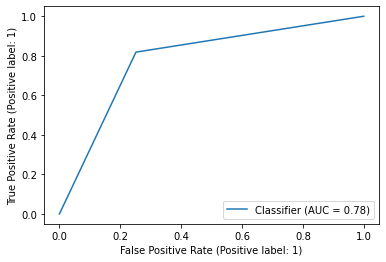

In [243]:
print('AUC score is', roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_pred)

## Support Vector Machine (with attempts at 'Grid' Search and CV)

The cell below was my first attempt with too many fits to handle. Each fit takes roughly 8 min or 480 seconds. I interrupted after 10 fits.

In [ ]:
# DO NOT RUN
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC

#C = [0.01,0.1,10,100] #5
#kernel = ['linear', 'poly', 'rbf', 'sigmoid'] #4
#degree = [1,2,3] #7

#parameters = dict(C=C,kernel=kernel,degree = degree)

#svc = SVC()

#svc_GS = GridSearchCV(svc,param_grid=parameters,verbose = 2)

#svc_GS.fit(X_train_std, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ....................C=0.01, degree=1, kernel=linear; total time= 7.4min
[CV] END ....................C=0.01, degree=1, kernel=linear; total time= 6.9min
[CV] END ....................C=0.01, degree=1, kernel=linear; total time= 6.8min
[CV] END ....................C=0.01, degree=1, kernel=linear; total time= 7.4min
[CV] END ....................C=0.01, degree=1, kernel=linear; total time= 7.4min
[CV] END ......................C=0.01, degree=1, kernel=poly; total time= 7.9min
[CV] END ......................C=0.01, degree=1, kernel=poly; total time= 8.0min
[CV] END ......................C=0.01, degree=1, kernel=poly; total time= 8.0min
[CV] END ......................C=0.01, degree=1, kernel=poly; total time= 8.7min
[CV] END ......................C=0.01, degree=1, kernel=poly; total time= 8.0min
[CV] END .......................C=0.01, degree=1, kernel=rbf; total time= 9.6min


I have to work with a smaller grid here to finish it in a reasonable time.

Edit: 1 hour later with 2 fits. Stackoverflow says the bigger the C, the longer it takes to fit.

I'll just work with 1 specification.

In [ ]:
# DO NOT RUN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#C = [0.1,1] #2
#kernel = ['linear','rbf'] #2

#parameters = dict(C=C,
                  kernel=kernel)

#svc = SVC()

#svc_GS = GridSearchCV(svc,param_grid=parameters,verbose = 2)

#svc_GS.fit(X_train_std, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...............................C=0.1, kernel=linear; total time=24.5min
[CV] END ...............................C=0.1, kernel=linear; total time=25.0min
[CV] END ...............................C=0.1, kernel=linear; total time=25.7min


In [25]:
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
startTime = datetime.now()
svc = SVC(kernel='rbf', C = 1, verbose=2)
svc.fit(X_train_std, y_train)
print(datetime.now() - startTime)

[LibSVM]0:13:20.829852


In [30]:
svc.score(X_test_std,y_test)

0.7678967104141811

In [31]:
from datetime import datetime
startTime = datetime.now()

svc2 = SVC(kernel='rbf', C = 0.1, verbose=2)
svc2.fit(X_train_std, y_train)
print(datetime.now() - startTime)
svc2.score(X_test_std,y_test)

[LibSVM]0:14:54.529587


In [32]:
svc2.score(X_test_std,y_test)

0.7394324186125788

In [34]:
svc3 = SVC(kernel='rbf', C = 10, verbose=2)
startTime = datetime.now()
svc3.fit(X_train_std, y_train)
print(datetime.now() - startTime)
svc3.score(X_test_std,y_test)

[LibSVM]1:23:11.682045


0.7546020112493609

In [ ]:
svc4 = SVC(kernel='linear', C = 1, verbose=2)
startTime = datetime.now()
svc4.fit(X_train_std, y_train)
print(datetime.now() - startTime)
svc4.score(X_test_std,y_test)

[LibSVM]

In [26]:
from sklearn.metrics import confusion_matrix

y_pred = svc.predict(X_test_std)
cmdf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmdf.ravel()
print(cmdf)
precision = round(tp/(tp+fp),3)
recall = round(tp/(tp+fn),3)
print('Precision {}'.format(precision))
print('recall {}'.format(recall))

[[8541 3216]
 [2231 9480]]
Precision 0.747
recall 0.809


In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.79      0.73      0.76     11757
        True       0.75      0.81      0.78     11711

    accuracy                           0.77     23468
   macro avg       0.77      0.77      0.77     23468
weighted avg       0.77      0.77      0.77     23468



AUC score is 0.7679780890502578


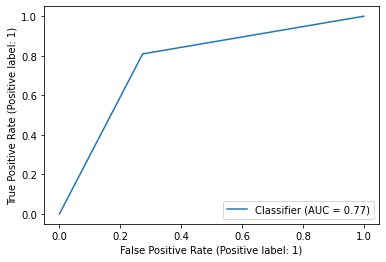

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
print('AUC score is', roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_pred)

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

xgb = XGBClassifier(random_state = 42,
                   objective = 'binary:logistic',
                   #verbosity = 2,
                   early_stopping_rounds=10,
                   n_jobs = 1)

params = {
        'gamma': [0, 0.25, 1.0],
        'reg_lambda':[0,1,10],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6],
        'learning_rate':[0.01,0.05,0.1]
        }

xgbgs = GridSearchCV(xgb, param_grid = params, verbose = 2, n_jobs = -1, cv = 3)


# Here we go
startTime = datetime.now()
xgbgs.fit(X_train, y_train)
print(datetime.now() - startTime) # timing ends here for "start_time" variable


In [36]:
xgbgs.best_score_

0.803425261302103

In [37]:
xgbb = xgbgs.best_estimator_

In [38]:
xgbb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, enable_categorical=False, gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=0, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [39]:
xgbb.score(X_test,y_test)

0.8042014658258053

In [40]:
from sklearn.metrics import confusion_matrix

y_pred = xgbb.predict(X_test)
cmdf = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cmdf.ravel()
print(cmdf)
precision = round(tp/(tp+fp),3)
recall = round(tp/(tp+fn),3)
print('Precision {}'.format(precision))
print('recall {}'.format(recall))

[[ 8554  3203]
 [ 1392 10319]]
Precision 0.763
recall 0.881


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.73      0.79     11757
        True       0.76      0.88      0.82     11711

    accuracy                           0.80     23468
   macro avg       0.81      0.80      0.80     23468
weighted avg       0.81      0.80      0.80     23468



AUC score is 0.8043519741448069


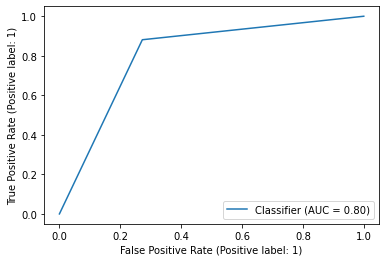

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
print('AUC score is', roc_auc_score(y_test, y_pred))
RocCurveDisplay.from_predictions(y_test, y_pred)